In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os, sys
# sys.path.append("/home/jovyan/pschizhov/ODE_for_Neural_Optimal_Transport")
sys.path.append("..")


ADJOINT = False
SOLVER_METHOD = 'euler'
SOLVER_TS = 10
TOL = 1e-4

DEVICE_IDS = [0]

T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 16

BATCH_SIZE = 64


# COST = 'mse' # Mean Squared Error
COST = 'dynamic_ot'

PLOT_INTERVAL = 100
CPKT_INTERVAL = 2000
MAX_STEPS = 100001
SEED = 0x000000

In [71]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from torchdyn.core import NeuralODE
import functorch
import einops
import wandb

assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
torch.manual_seed(SEED); np.random.seed(SEED)
torch.cuda.is_available()

import os, sys
import time
from tqdm import tqdm
import gc

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from models.models import Unet
from models.ode import ODEBlock2
from models.simple_mlp import SimpleSequential, SimpleSequentialTimed

from src_not.resnet2 import ResNet_D
from src_not.tools import unfreeze, freeze
from src_not import distributions
from src_not.tools import weights_init_D
from src_not.tools import load_dataset, get_pushed_loader_stats
from src_not.fid_score import calculate_frechet_distance
from src_not.plotters import plot_random_images, plot_images

from copy import deepcopy
import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import wandb # <--- online logging of the results
from src_not.tools import fig2data, fig2img # for wandb

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

In [4]:
# ode_f = Unet(16).cuda()
# T = ODEBlock2(ode_f,
#               t_eval=torch.linspace(0,1,SOLVER_TS).float(),
#              sensitivity='adjoint' if ADJOINT else'autograd',
#               method=SOLVER_METHOD).cuda()

# f = ResNet_D(IMG_SIZE, nc=3, nfilter=64, nfilter_max=256).cuda()

0. 8 Гауссиан в moon dataset
1. 5 шагов эйлера, без adjointa -> потому что не честно решаем ОДУ -> чтобы показать, разрешение 32, fid раз в 1000 шагов (должен быть убывающим). Это скорее всего будет работать за адекватное время, но проблема с возвращением назад, для этого добавляем регуляризатор со случайной точкой на траекториии в [0, 1] -> есть шанс, возможно можно будет обратить.



In [7]:
BATCH_SIZE = 64

def random_color(im):
    hue = 360*np.random.rand()
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

TRANSFORM = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    random_color,
    transforms.Normalize([0.5],[0.5])
])

# Load train datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM)
idx = np.array(range(len(mnist_train)))
mnist_2 = torch.utils.data.Subset(mnist_train, idx[mnist_train.targets==2])
mnist_3 = torch.utils.data.Subset(mnist_train, idx[mnist_train.targets==3])
mnist_2_loader = torch.utils.data.DataLoader(mnist_2, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
mnist_3_loader = torch.utils.data.DataLoader(mnist_3, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Load test datasets
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM)
idx = np.array(range(len(mnist_test)))
mnist_2_test = torch.utils.data.Subset(mnist_test, idx[mnist_test.targets==2])
mnist_3_test = torch.utils.data.Subset(mnist_test, idx[mnist_test.targets==3])
mnist_2_test_loader = torch.utils.data.DataLoader(mnist_2_test, batch_size=BATCH_SIZE)
mnist_3_test_loader = torch.utils.data.DataLoader(mnist_3_test, batch_size=BATCH_SIZE)

# We pick a few samples from them for the qualitative analysis
X_test_fixed = next(iter(mnist_2_test_loader))[0]
Y_test_fixed = next(iter(mnist_3_test_loader))[0]
Z_test_fixed = torch.randn(BATCH_SIZE, 4, 1, 16, 16)
with torch.no_grad():
    XZ_test_fixed = torch.cat([X_test_fixed[:,None].repeat(1,4,1,1,1), Z_test_fixed], dim=2)
del Z_test_fixed

# del mnist_2_test_loader, mnist_3_test_loader, mnist_2_test, mnist_3_test, mnist_test

In [49]:
from src_not.tools import load_dataset, get_pushed_loader_stats
from src_not.fid_score import calculate_frechet_distance


In [25]:
from src_not.distributions import LoaderSampler
from src_not.tools import get_loader_stats
import json

batch_size = 64
device = 'cuda'
# train_sampler_x = LoaderSampler(DataLoader(mnist_2, shuffle=True, num_workers=8, batch_size=batch_size), device)
test_sampler_x = LoaderSampler(torch.utils.data.DataLoader(mnist_2_test, shuffle=True, num_workers=8, batch_size=batch_size), device)
# train_sampler_y = LoaderSampler(DataLoader(mnist_3, shuffle=True, num_workers=8, batch_size=batch_size), device)
test_sampler_y = LoaderSampler(torch.utils.data.DataLoader(mnist_3_test, shuffle=True, num_workers=8, batch_size=batch_size), device)

mu, sigma = get_loader_stats(test_sampler_x.loader)
print('Trace of sigma: {}'.format(np.trace(sigma)))
stats = {'mu' : mu.tolist(), 'sigma' : sigma.tolist()}
print('Stats computed')

filename = 'MNIST2_16_test.json'
with open(filename, 'w') as fp:
    json.dump(stats, fp)
print('States saved to {}'.format(filename))

mu, sigma = get_loader_stats(test_sampler_y.loader)
print('Trace of sigma: {}'.format(np.trace(sigma)))
stats = {'mu' : mu.tolist(), 'sigma' : sigma.tolist()}
print('Stats computed')

filename = 'MNIST3_16_test.json'
with open(filename, 'w') as fp:
    json.dump(stats, fp)
print('States saved to {}'.format(filename))

Trace of sigma: 67.09495203287128
Stats computed
States saved to MNIST2_16_test.json
Trace of sigma: 68.28845786956977
Stats computed
States saved to MNIST3_16_test.json


In [26]:
filename = 'MNIST3_16_test.json'
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data_y, sigma_data_y = data_stats['mu'], data_stats['sigma']
del data_stats
filename = 'MNIST2_16_test.json'
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data_x, sigma_data_x = data_stats['mu'], data_stats['sigma']
del data_stats

1032

In [ ]:
len(mnist_2)

In [31]:
ind = np.random.choice(3, size=10)
print(ind)

[1 2 1 0 0 1 2 1 1 2]


In [34]:
ind = np.random.choice(3, size=10)
print(ind)
hui = torch.zeros(10, 3)
hui[range(len(hui)), ind] = 1
print(hui)

tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [45]:
from pathlib import Path
list_dir = list(Path('checkpoints/dynamic_ot_euler10step_MNIST_23').iterdir()) 
gen_pt_path_lst = [f for f in list_dir if f.name.startswith('0')]

In [43]:
ADJOINT = False
SOLVER_TS=10
class Last_T(nn.Module):
    def __init__(self, T):
        super(Last_T, self).__init__()
        self.T = T
    def forward(self, x):
        res = self.T(x)
        return res[0]
    
ode_f = Unet(16).cuda()
T = ODEBlock2(ode_f,
              t_eval=torch.linspace(0,1,SOLVER_TS).float(),
             sensitivity='adjoint' if ADJOINT else'autograd',
              method=SOLVER_METHOD).cuda()

In [51]:
BATCH_SIZE = 64
num_steps = 10
fids = {'forward': {}, 'backward' : {}}
for path in gen_pt_path_lst:
    print('Forward', path)
    T.load_state_dict(torch.load(path))
    T.eval()
    mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_x.loader, batch_size=BATCH_SIZE, verbose=True)
    fid = calculate_frechet_distance(mu_data_y, sigma_data_y, mu, sigma)
    print(fid)
    fids['forward'][str(path.name)] = fid  

    print('Backward', path)
    int_time = T.integration_time
    new_int_time = torch.linspace(0, 1, num_steps).flip(dims=(0,))
    T.integration_time = new_int_time
    mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_y.loader, batch_size=BATCH_SIZE, verbose=True)
    fid = calculate_frechet_distance(mu_data_x, sigma_data_x, mu, sigma)
    T.integration_time = int_time
    print(fid)
    fids['backward'][str(path.name)] = fid
    


Forward checkpoints/dynamic_ot_euler10step_MNIST_23/0_0.pt


0it [00:00, ?it/s]

234.24757626070965
Backward checkpoints/dynamic_ot_euler10step_MNIST_23/0_0.pt


0it [00:00, ?it/s]

226.7132857563328
Forward checkpoints/dynamic_ot_euler10step_MNIST_23/0_1.pt


0it [00:00, ?it/s]

172.0615255518902
Backward checkpoints/dynamic_ot_euler10step_MNIST_23/0_1.pt


0it [00:00, ?it/s]

182.8844351815421
Forward checkpoints/dynamic_ot_euler10step_MNIST_23/0_1999.pt


0it [00:00, ?it/s]

21.965616639776982
Backward checkpoints/dynamic_ot_euler10step_MNIST_23/0_1999.pt


0it [00:00, ?it/s]

120.52941458173227
Forward checkpoints/dynamic_ot_euler10step_MNIST_23/0_3999.pt


0it [00:00, ?it/s]

13.636739512376067
Backward checkpoints/dynamic_ot_euler10step_MNIST_23/0_3999.pt


0it [00:00, ?it/s]

110.30158005966449


In [52]:
fids

{'forward': {'0_0.pt': 234.24757626070965,
  '0_1.pt': 172.0615255518902,
  '0_1999.pt': 21.965616639776982,
  '0_3999.pt': 13.636739512376067},
 'backward': {'0_0.pt': 226.7132857563328,
  '0_1.pt': 182.8844351815421,
  '0_1999.pt': 120.52941458173227,
  '0_3999.pt': 110.30158005966449}}

In [ ]:
BATCH_SIZE = 64
num_steps = 10
fids = {'forward': {}, 'backward' : {}}
for path in gen_pt_path_lst:
    print('Forward', path)
    T.load_state_dict(torch.load(path))
    T.eval()
    mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_x.loader, batch_size=BATCH_SIZE, verbose=True)
    fid = calculate_frechet_distance(mu_data_y, sigma_data_y, mu, sigma)
    print(fid)
    fids['forward'][str(path.name)] = fid  

    print('Backward', path)
    int_time = T.integration_time
    new_int_time = torch.linspace(0, 1, num_steps).flip(dims=(0,))
    T.integration_time = new_int_time
    mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_y.loader, batch_size=BATCH_SIZE, verbose=True)
    fid = calculate_frechet_distance(mu_data_x, sigma_data_x, mu, sigma)
    T.integration_time = int_time
    print(fid)
    fids['backward'][str(path.name)] = fid

In [53]:
ADJOINT = True
SOLVER_TS=10
class Last_T(nn.Module):
    def __init__(self, T):
        super(Last_T, self).__init__()
        self.T = T
    def forward(self, x):
        res = self.T(x)
        return res[0]
    
ode_f = Unet(16).cuda()
T = ODEBlock2(ode_f,
              t_eval=torch.linspace(0,1,SOLVER_TS).float(),
             sensitivity='adjoint' if ADJOINT else'autograd',
              method=SOLVER_METHOD).cuda()

list_dir = list(Path('checkpoints/dynamic_ot_euler10step_MNIST_23_adjoint').iterdir()) 
gen_pt_path_lst = [f for f in list_dir if f.name.startswith('0')]

BATCH_SIZE = 64
num_steps = 10
fids = {'forward': {}, 'backward' : {}}
for path in gen_pt_path_lst:
    print('Forward', path)
    T.load_state_dict(torch.load(path))
    T.eval()
    mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_x.loader, batch_size=BATCH_SIZE, verbose=True)
    fid = calculate_frechet_distance(mu_data_y, sigma_data_y, mu, sigma)
    print(fid)
    fids['forward'][str(path.name)] = fid  

    print('Backward', path)
    int_time = T.integration_time
    new_int_time = torch.linspace(0, 1, num_steps).flip(dims=(0,))
    T.integration_time = new_int_time
    mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_y.loader, batch_size=BATCH_SIZE, verbose=True)
    fid = calculate_frechet_distance(mu_data_x, sigma_data_x, mu, sigma)
    T.integration_time = int_time
    print(fid)
    fids['backward'][str(path.name)] = fid

Forward checkpoints/dynamic_ot_euler10step_MNIST_23_adjoint/0_999.pt


0it [00:00, ?it/s]

31.899520357900997
Backward checkpoints/dynamic_ot_euler10step_MNIST_23_adjoint/0_999.pt


0it [00:00, ?it/s]

177.80723716748733


In [75]:
kostil_t = torch.cat((torch.linspace(0, 0.9, SOLVER_TS), torch.tensor([0.95, 0.99,0.999, 1])), dim = 0)

In [76]:

ADJOINT = False
SOLVER_TS=10
class Last_T(nn.Module):
    def __init__(self, T):
        super(Last_T, self).__init__()
        self.T = T
    def forward(self, x):
        res = self.T(x)
        return res[0]
    
ode_f = Unet(16).cuda()
T = ODEBlock2(ode_f,
              t_eval=kostil_t.float(),
              sensitivity='adjoint' if ADJOINT else'autograd',
              method=SOLVER_METHOD).cuda()


In [ ]:
hz = T(torch.rand(15, 3, 16, 16).cuda())

t=  tensor(0., device='cuda:0')
t=  tensor(0.1000, device='cuda:0')
t=  tensor(0.2000, device='cuda:0')
t=  tensor(0.3000, device='cuda:0')
t=  tensor(0.4000, device='cuda:0')
t=  tensor(0.5000, device='cuda:0')
t=  tensor(0.6000, device='cuda:0')
t=  tensor(0.7000, device='cuda:0')
t=  tensor(0.8000, device='cuda:0')
t=  tensor(0.9000, device='cuda:0')
t=  tensor(0.9500, device='cuda:0')
t=  tensor(0.9900, device='cuda:0')
t=  tensor(0.9990, device='cuda:0')


In [6]:
iter_mnist_2, iter_mnist_3 = iter(mnist_2_loader), iter(mnist_3_loader)

def sample_mnist_2():
    global iter_mnist_2, mnist_2_loader
    try:
        return next(iter_mnist_2)[0]
    except StopIteration:
        iter_mnist_2 = iter(mnist_2_loader)
        return next(iter_mnist_2)[0]

def sample_mnist_3():
    global iter_mnist_3, mnist_3_loader
    try:
        return next(iter_mnist_3)[0]
    except StopIteration:
        iter_mnist_3 = iter(mnist_3_loader)
        return next(iter_mnist_3)[0]
    
    

Random (unpaired) images from Colored MNIST-2 (1st row) and Colored MNIST-3 (2nd row) train sets


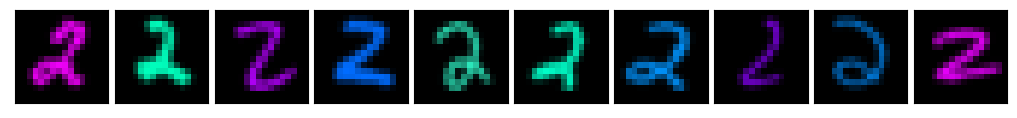

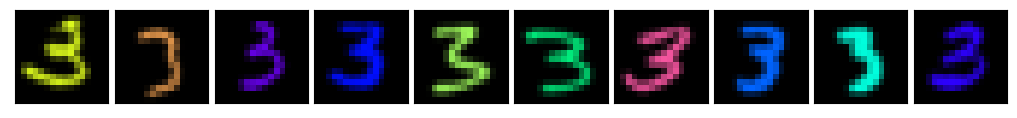

In [7]:
def plot_images(batch):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1), dpi=100)
    for i in range(10):
        axes[i].imshow(batch[i].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
        axes[i].set_xticks([]); axes[i].set_yticks([])
    fig.tight_layout(pad=0.1)

print('Random (unpaired) images from Colored MNIST-2 (1st row) and Colored MNIST-3 (2nd row) train sets')
plot_images(sample_mnist_2())
plot_images(sample_mnist_3())

In [8]:
def plot_trajectories(generator,
                      batch_size,
                      X_train_sampler,
                      Y_train_sampler,
                      num_steps=25,
                      backward=False):
    
    global X_test_fixed, Y_test_fixed
    
    with torch.no_grad():          
        int_time = generator.integration_time
        new_int_time = torch.linspace(0, 1, num_steps)
        if backward:
            new_int_time = torch.linspace(0, 1, num_steps).flip(dims=(0,))
            X_test_fixed, Y_test_fixed = Y_test_fixed, X_test_fixed
            
        generator.integration_time = new_int_time 
       
        plot_time = min(num_steps, 10)
        step_time = max(plot_time // 10, 1)
        batch_size = min(batch_size, 10)
        
        # Test fixed
        fig1, axes1 = plt.subplots(plot_time + 1, batch_size, figsize=(plot_time + 1, batch_size), dpi=100)
        _, traj_test_fixed, _ = generator(torch.tensor(X_test_fixed[:batch_size], device='cuda'), return_trajectory=True)
        traj_test_fixed = traj_test_fixed.detach().cpu()
        for i in range(0, plot_time + 1, step_time):
            for j in range(batch_size):
                if i != plot_time:
                    axes1[i][j].imshow(traj_test_fixed[i, j].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
                    axes1[i][j].set_xticks([]); axes1[i][j].set_yticks([])
                else:
                    axes1[i][j].imshow(Y_test_fixed[j].mul(0.5).add(0.5).clip(0,1).permute(1,2,0).detach().cpu())
                    axes1[i][j].set_xticks([]); axes1[i][j].set_yticks([])
            fig1.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.95])
        if backward:
            fig1.suptitle('Backward fixed test')
        else:
            fig1.suptitle('Fixed test')
        
            
        if backward:
            X_train, Y_train = Y_train_sampler(), X_train_sampler()
        else:
            X_train, Y_train = X_train_sampler(), Y_train_sampler()
            
        fig4, axes4 = plt.subplots(plot_time + 1, batch_size, figsize=(plot_time + 1, batch_size), dpi=100)
        _, traj_train, _ = generator(torch.tensor(X_train, device='cuda'), return_trajectory=True)
        traj_train = traj_train.detach().cpu()
        for i in range(0, plot_time + 1, step_time):
            for j in range(batch_size):
                if i != plot_time:
                    axes4[i][j].imshow(traj_train[i, j].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
                    axes4[i][j].set_xticks([]); axes4[i][j].set_yticks([])
                else:
                    axes4[i][j].imshow(Y_train[j].mul(0.5).add(0.5).clip(0,1).permute(1,2,0).detach().cpu())
                    axes4[i][j].set_xticks([]); axes4[i][j].set_yticks([])
            fig4.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.95])
        if backward:
            fig4.suptitle('Backward train')
        else:
            fig4.suptitle('Train')
        
        
        
        generator.integration_time = int_time
        if backward:
            X_test_fixed, Y_test_fixed = Y_test_fixed, X_test_fixed
       

    return [fig1, fig4], [axes1, axes4]  
    

In [9]:
# plot_trajectories(T, BATCH_SIZE,
#                   sample_mnist_2,
#                   sample_mnist_3,
#                   num_steps=10,
#                   backward=False)

In [10]:
def train_loop(T, f, X_sampler, Y_sampler, BATCH_SIZE, T_ITERS=10, MAX_STEPS=100001, regularized=True):

    wandb.init(project='ode_strong_not', name=f'dynamic_ot_euler10step_MNIST_23_adjoint') 
    OUTPUT_PATH = f'checkpoints/dynamic_ot_euler10step_MNIST_23_adjoint'
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    T_LR = 1e-4
    f_LR = 1e-4
    
    T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
    f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)
    
    for step in tqdm(range(MAX_STEPS)):
        # T optimization
        unfreeze(T); freeze(f)
        avg_gen_opt_step_time = 0
        avg_num_func_eval_per_opt_step = 0
        for t_iter in range(T_ITERS):

            generator_opt_step_time = time.time()
            T_opt.zero_grad()
            X = X_sampler().cuda()

            t_eval, trajectories, reg_loss = T(X, return_trajectory=True)
            T_X = trajectories[-1]

            # total_loss
            if COST == 'mse':
                T_loss = F.mse_loss(X, T_X).mean() - f(T_X).mean() + reg_loss      
            elif COST == 'dynamic_ot':
                T_loss = reg_loss - f(T_X).mean() 
            else:
                raise Exception('Unknown COST')

            with torch.no_grad():
                num_func_eval = T.nfe
            T_loss.backward(); T_opt.step()
            with torch.no_grad():
                num_func_eval_per_opt_step = T.nfe - num_func_eval

            generator_opt_step_time = time.time() - generator_opt_step_time
            avg_gen_opt_step_time += generator_opt_step_time
            avg_num_func_eval_per_opt_step += num_func_eval_per_opt_step

        avg_gen_opt_step_time /= T_ITERS 
        avg_num_func_eval_per_opt_step /= T_ITERS
        # del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()
        
        # f optimization
        freeze(T); unfreeze(f)
        discriminator_opt_step_time = time.time()
        X = X_sampler().cuda()
        with torch.no_grad():
            T_X, _ = T(X)
        Y = Y_sampler().cuda()
        f_opt.zero_grad()
        f_loss = f(T_X).mean() - f(Y).mean()
        f_loss.backward(); f_opt.step();
        discriminator_opt_step_time = time.time() - discriminator_opt_step_time
        wandb.log({'f_loss' : f_loss.item(),
                   'T_loss' : T_loss.item(),
                   'reg_loss' : reg_loss.item(),
                  'avg_num_func_eval_per_opt_step' : avg_num_func_eval_per_opt_step,
                  'avg_gen_opt_step_time' : avg_gen_opt_step_time,
                  'discriminator_opt_step_time' : discriminator_opt_step_time
                  }, step=step) 

        if step % PLOT_INTERVAL == 0:
            print('Plotting')
            # clear_output(wait=True)
            figs, axes = plot_trajectories(T, BATCH_SIZE,
                                              sample_mnist_2,
                                              sample_mnist_3,
                                              num_steps=10,
                                              backward=False)
            figs_total = figs
            figs, axes = plot_trajectories(T, BATCH_SIZE,
                              sample_mnist_2,
                              sample_mnist_3,
                              num_steps=10,
                              backward=True)
            figs_total += figs

            wandb.log({'Fixed Images' : [wandb.Image(fig) for fig in figs_total]}, step=step) 
            [plt.show(fig) for fig in figs_total]; [plt.close(fig) for fig in figs_total]

        if step % CPKT_INTERVAL == CPKT_INTERVAL - 1:

            torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
            torch.save(f.state_dict(), os.path.join(OUTPUT_PATH, f'f_{SEED}_{step}.pt'))
            torch.save(f_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_opt_{SEED}_{step}.pt'))
            torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))

/home/user/conda/lib/python3.7/site-packages/notebook/utils.py:282: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Currently logged in as: peter_chizhov. Use `wandb login --relogin` to force relogin


  0%|          | 0/100001 [00:00<?, ?it/s]/home/user/conda/lib/python3.7/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


Plotting


/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


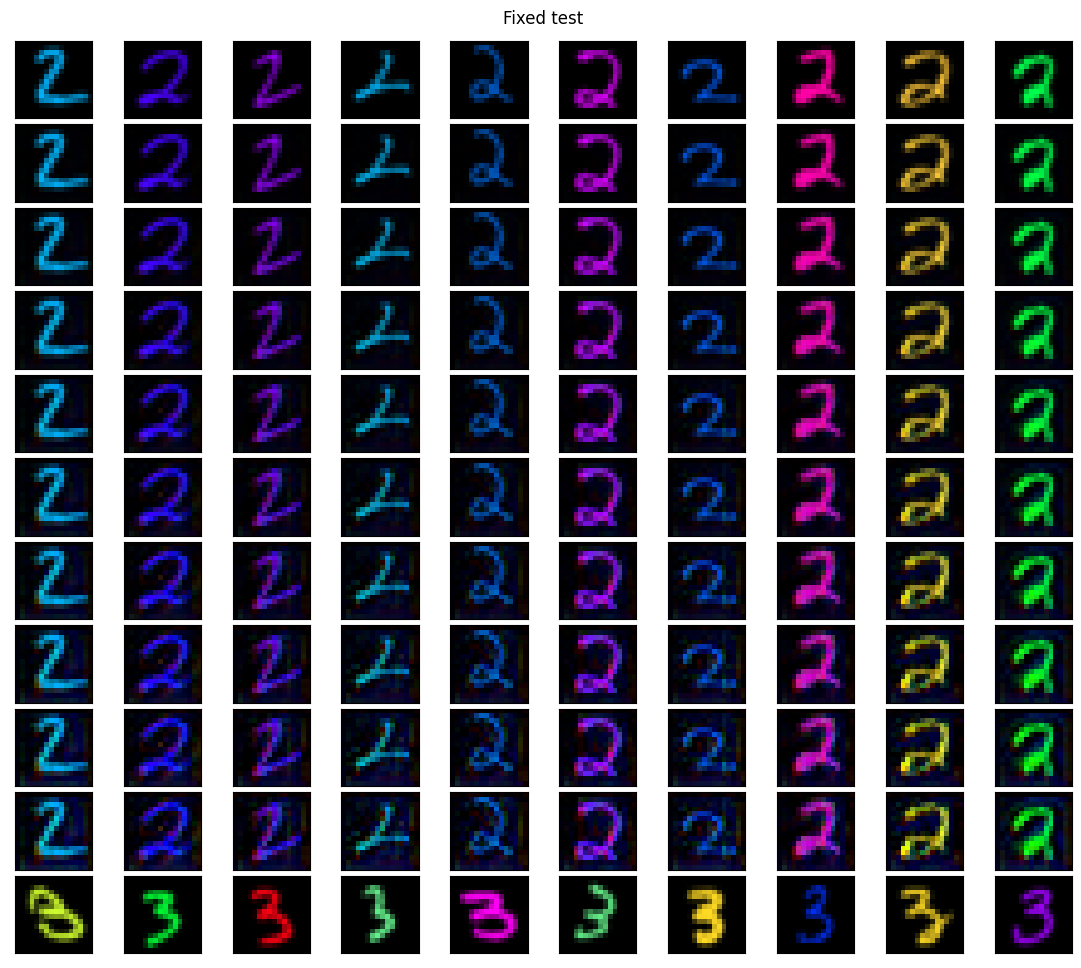

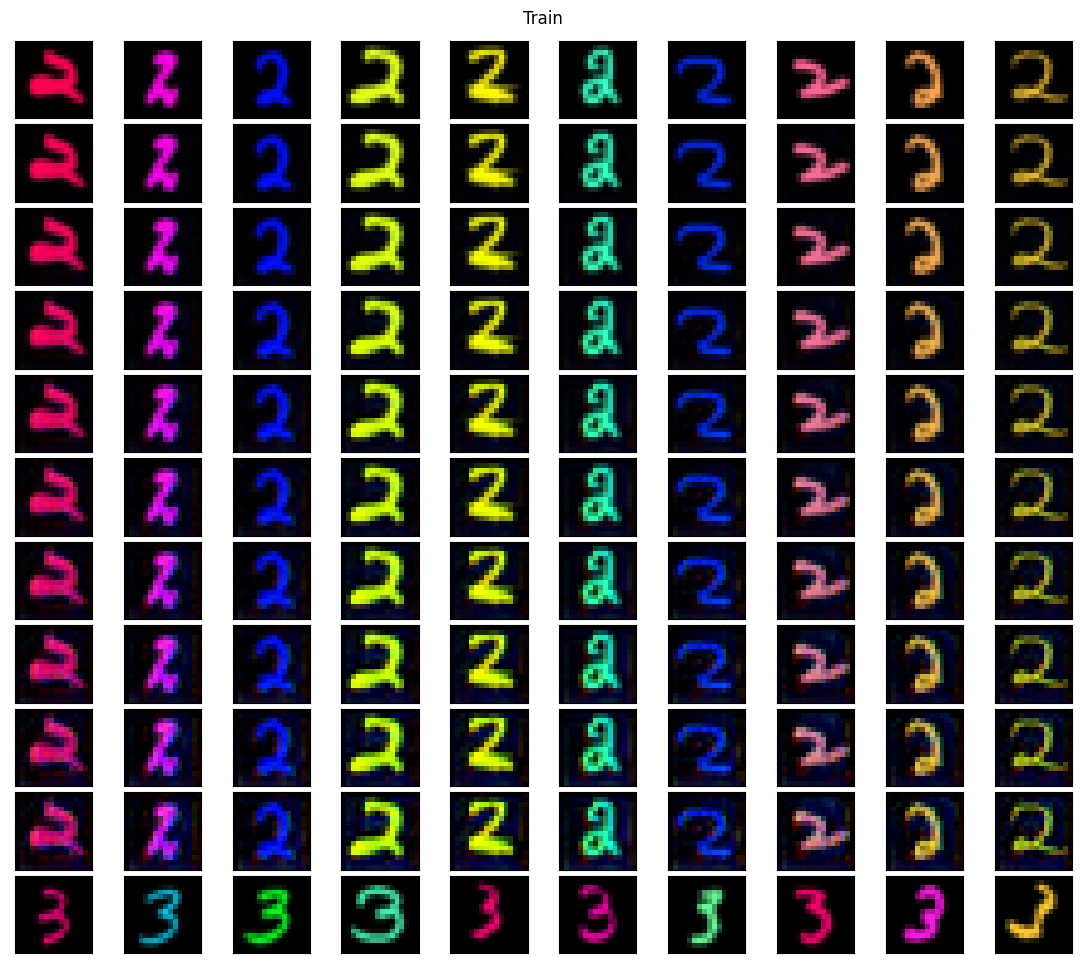

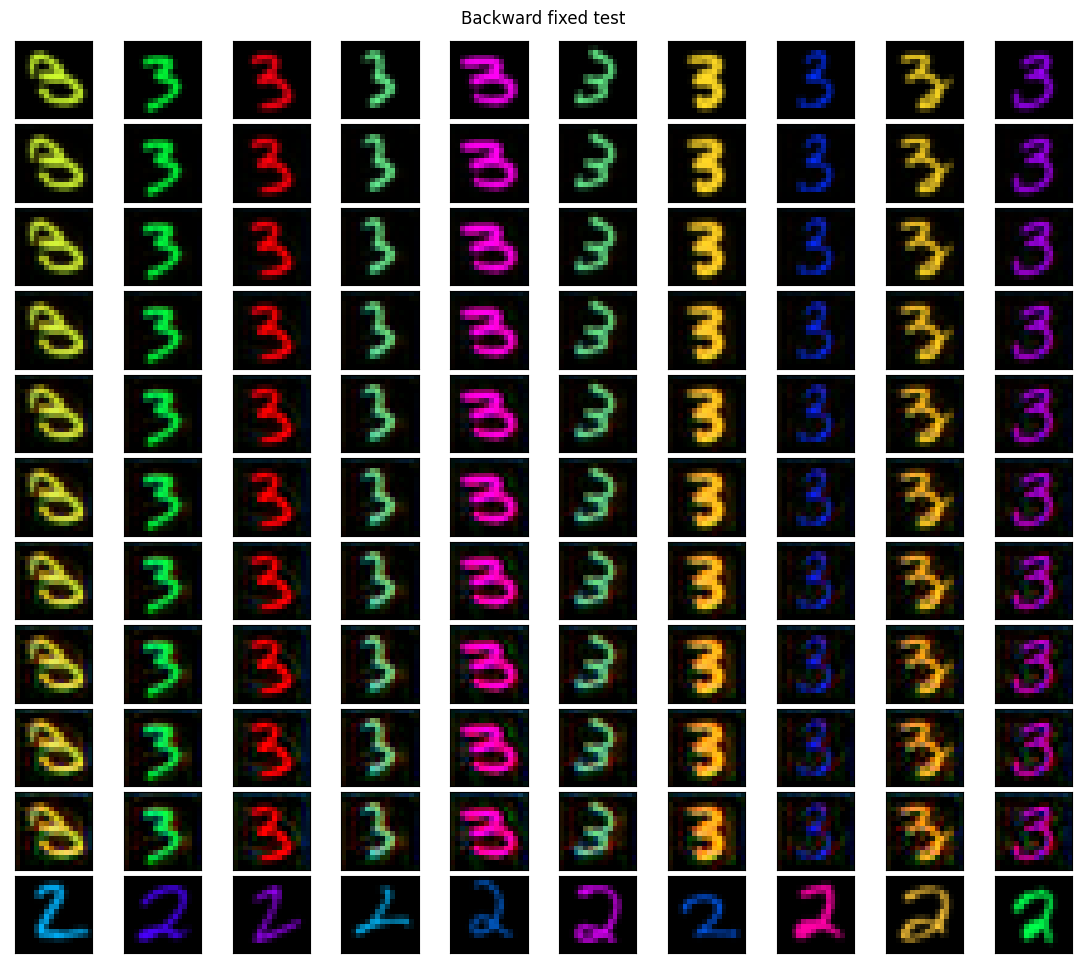

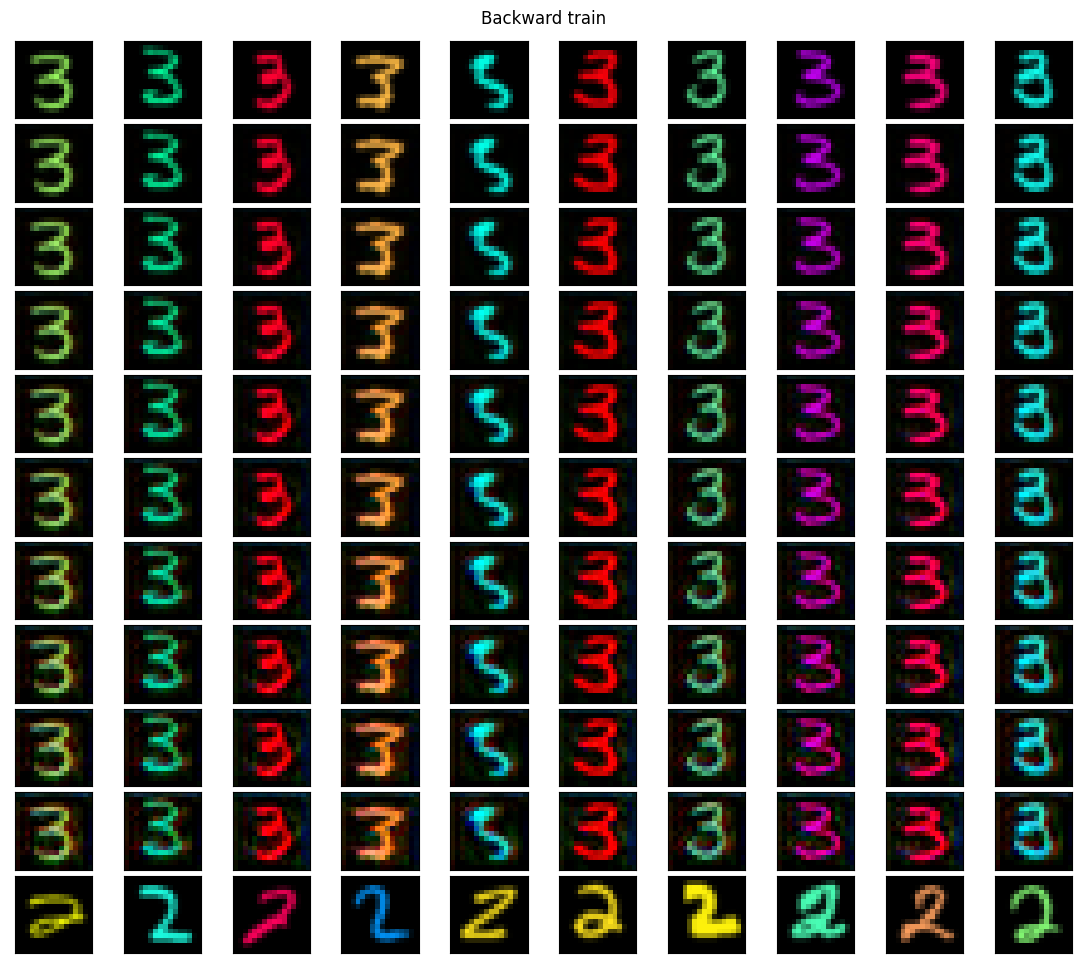

  0%|          | 100/100001 [22:14<358:54:45, 12.93s/it]

Plotting


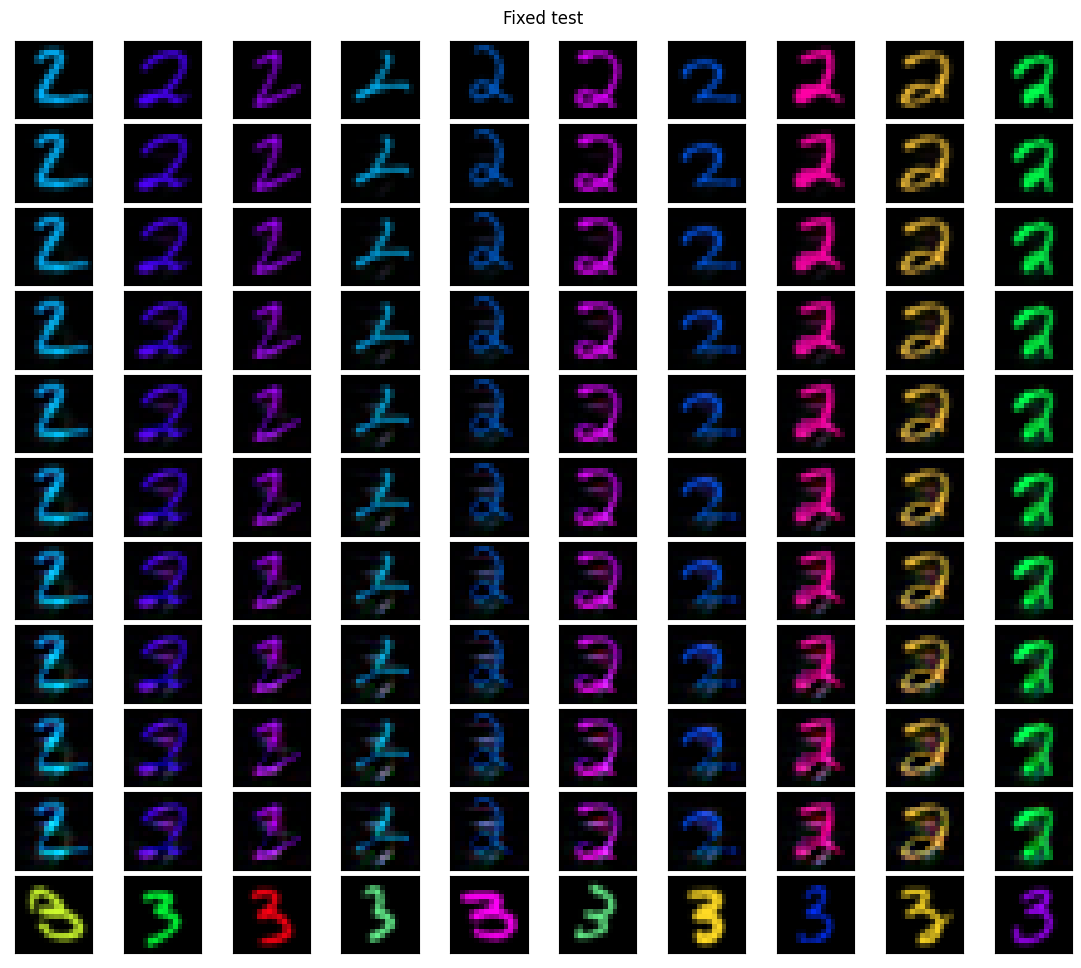

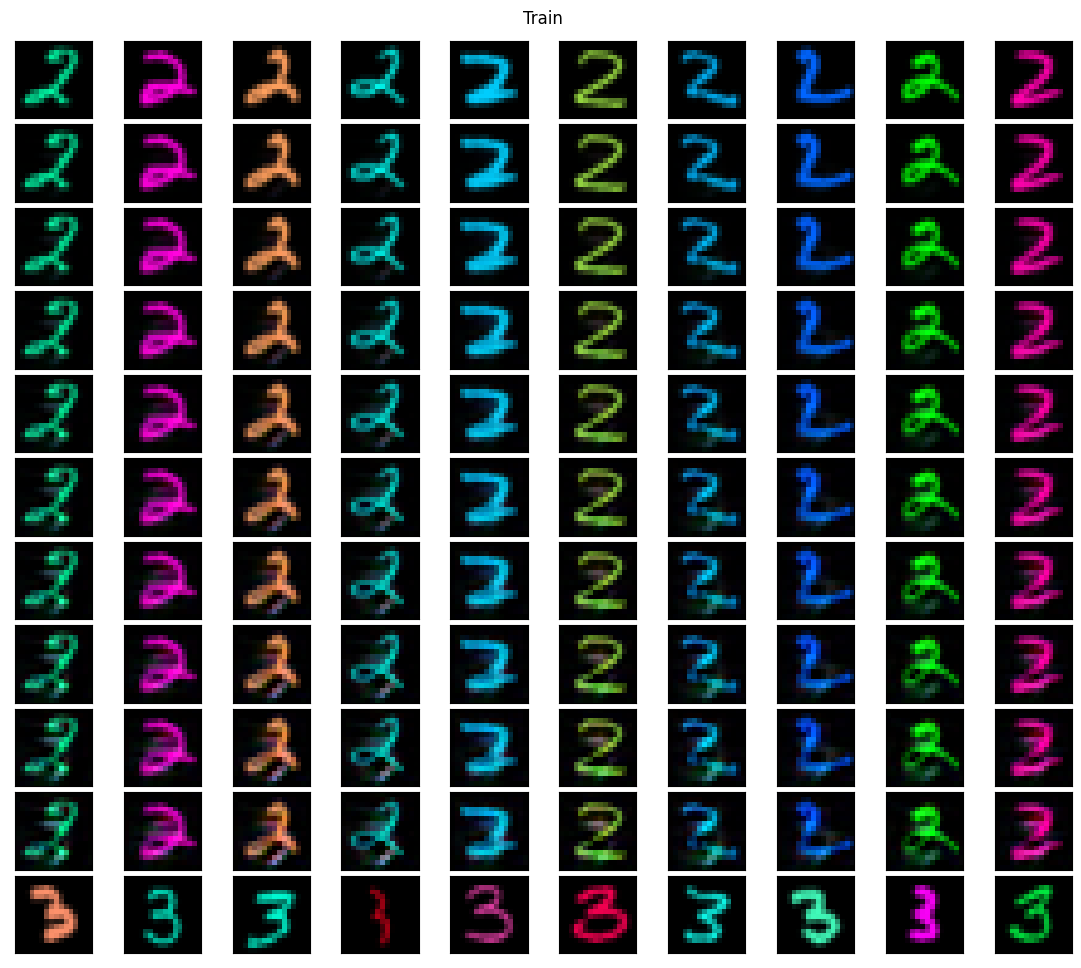

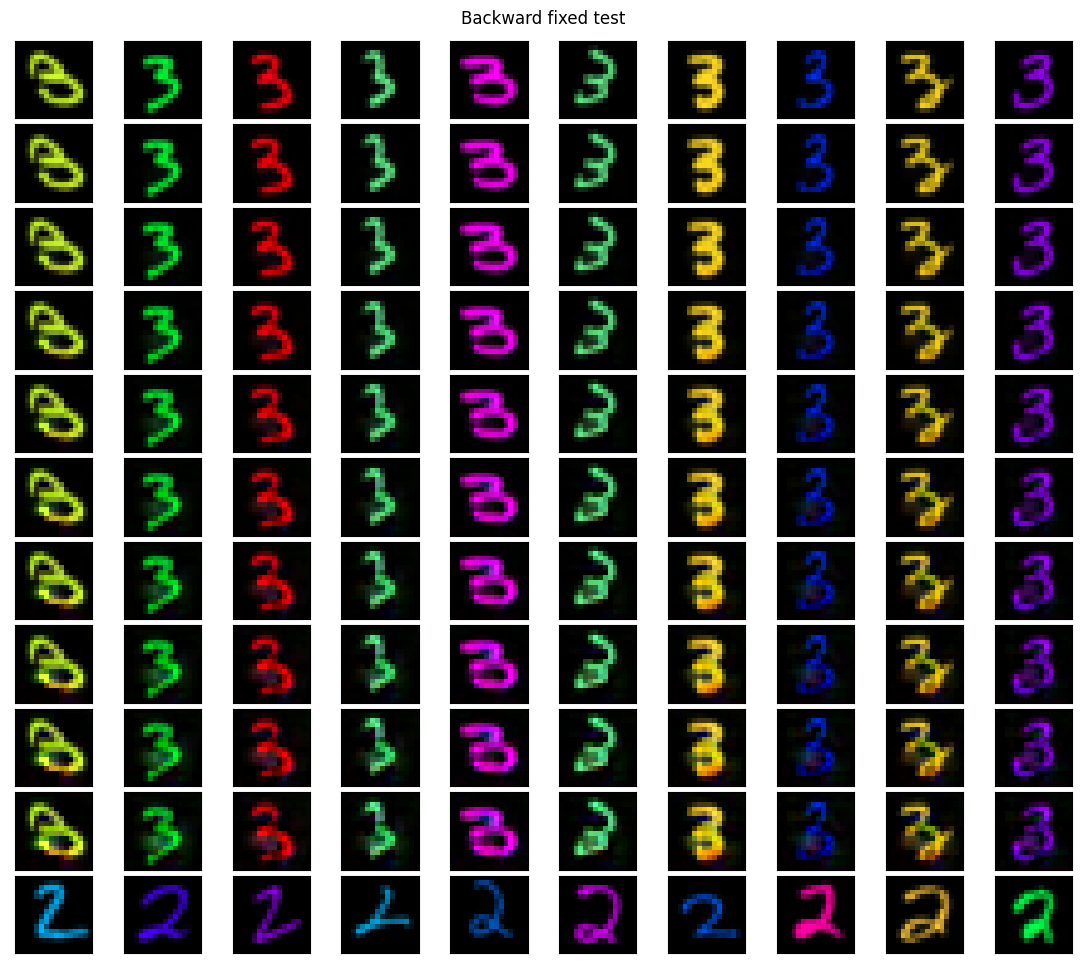

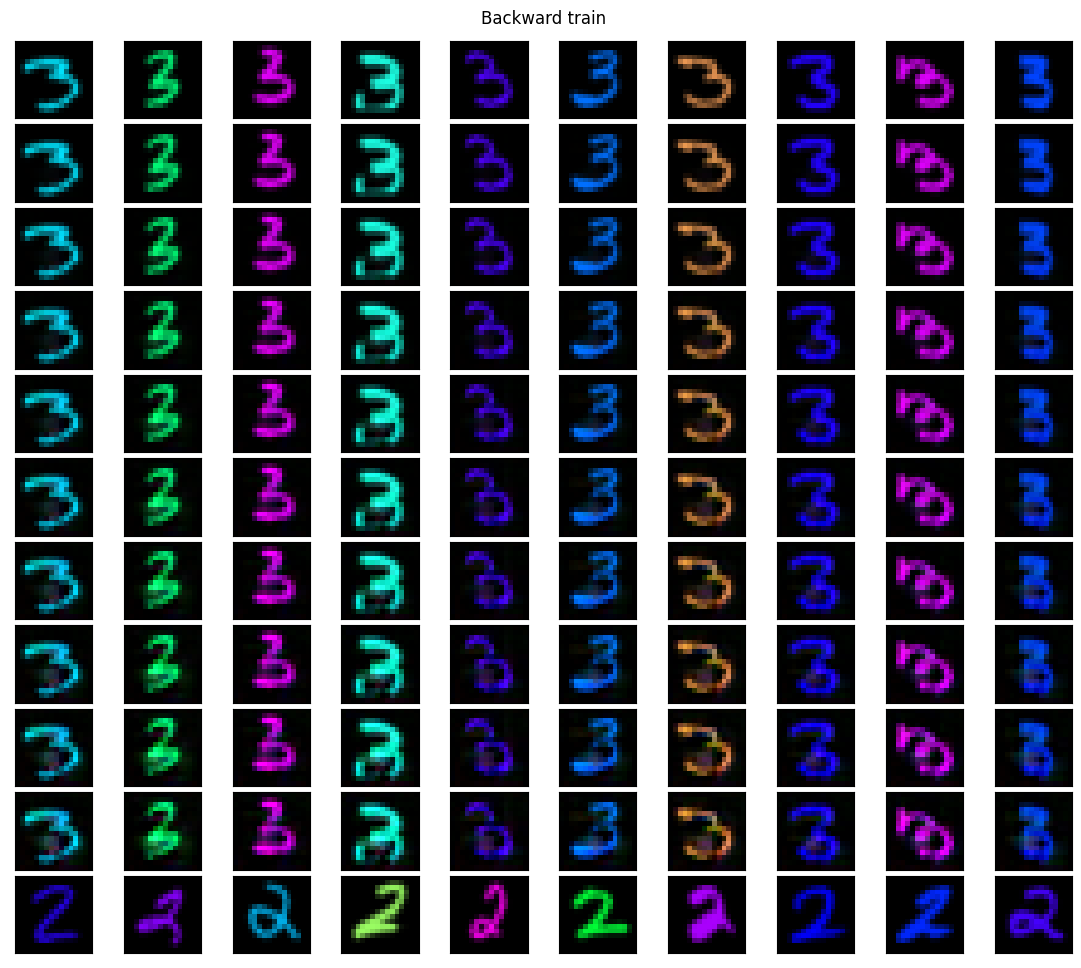

  0%|          | 200/100001 [44:32<359:40:06, 12.97s/it]

Plotting


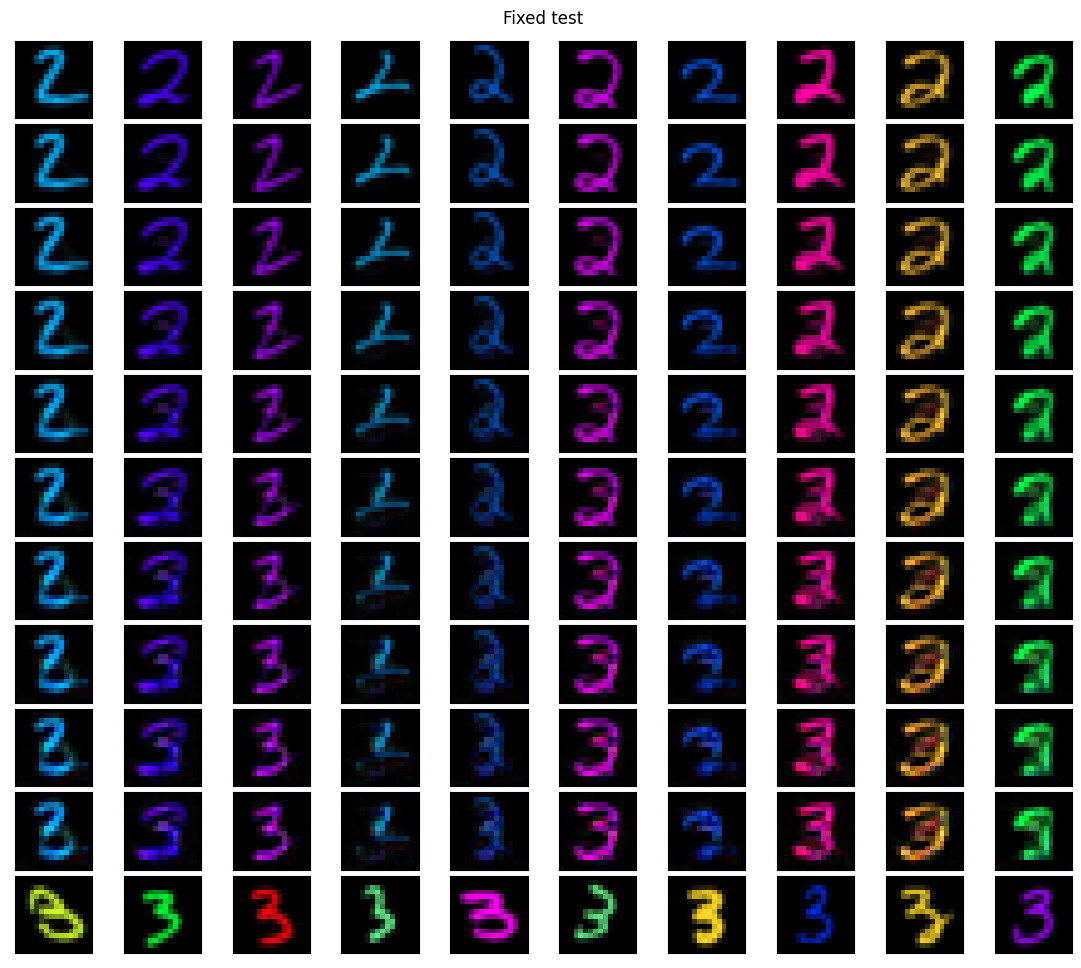

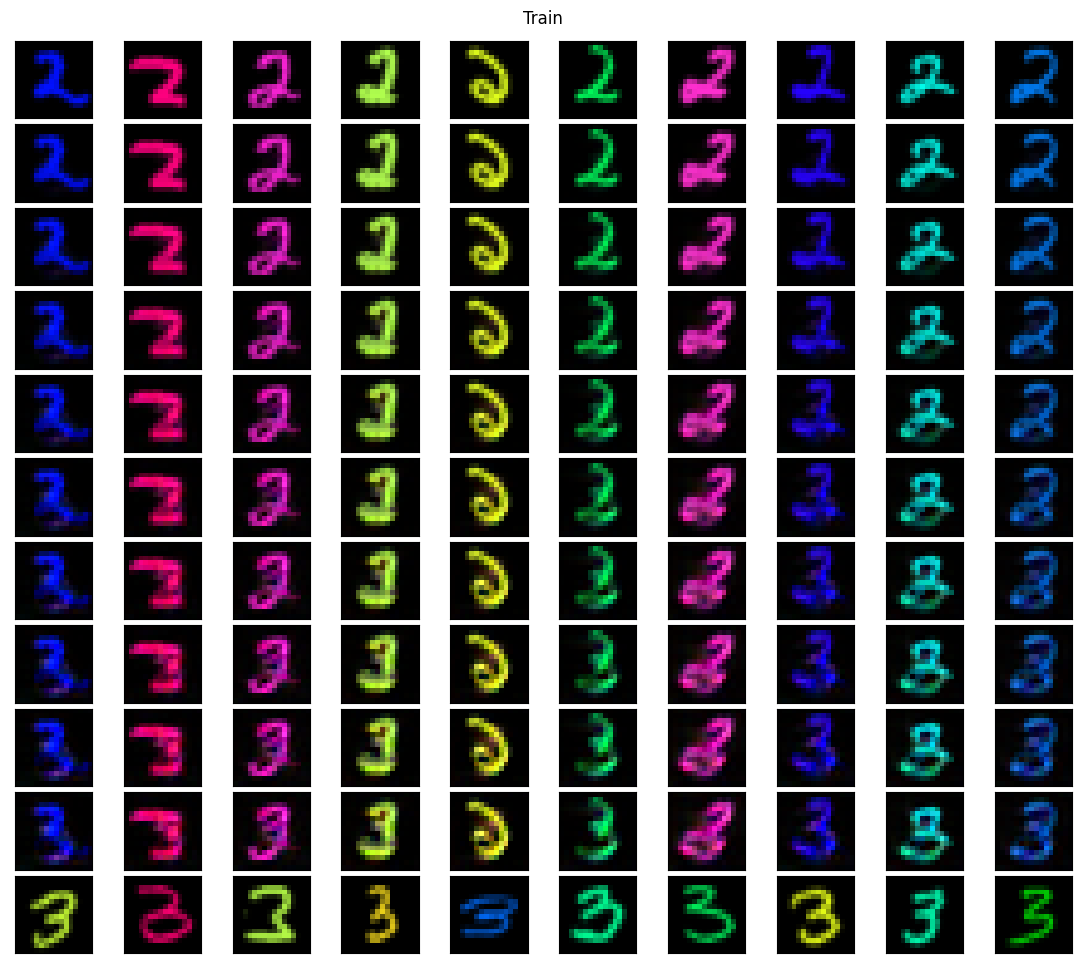

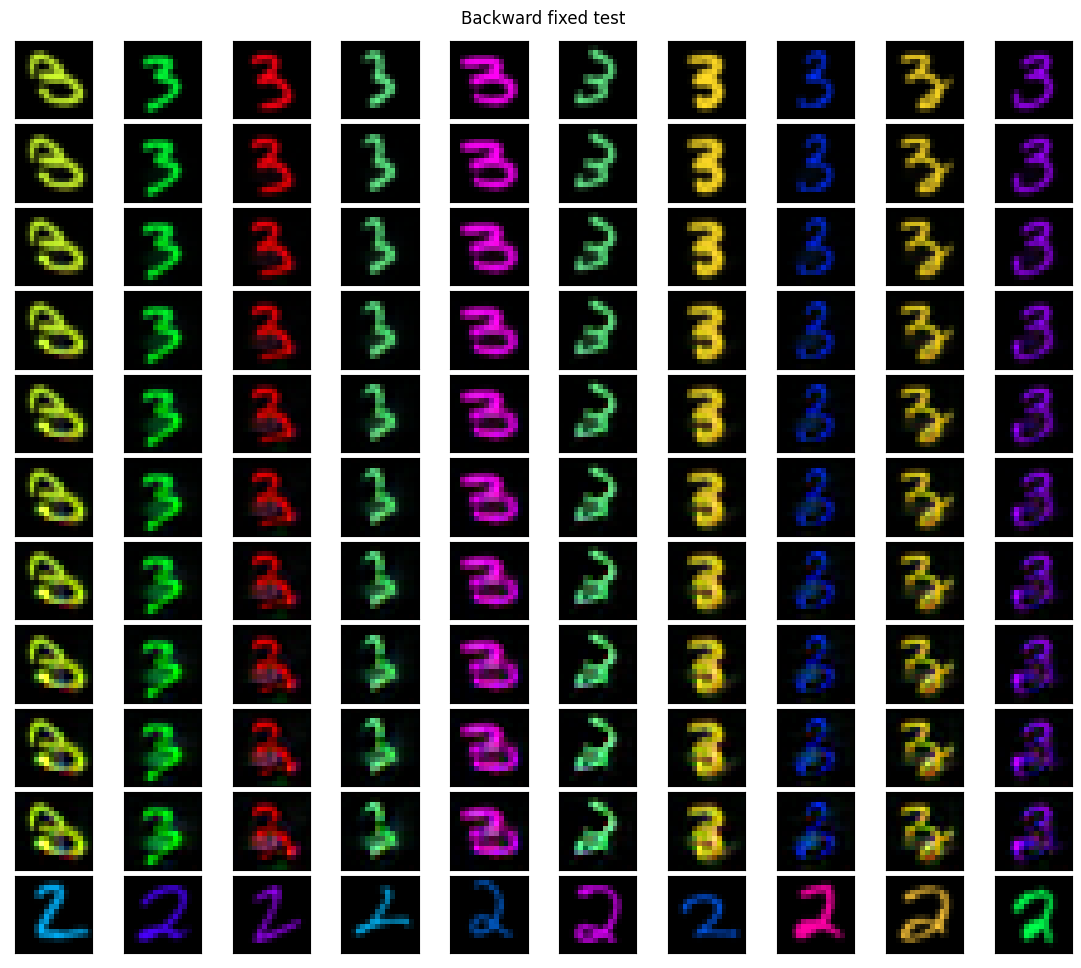

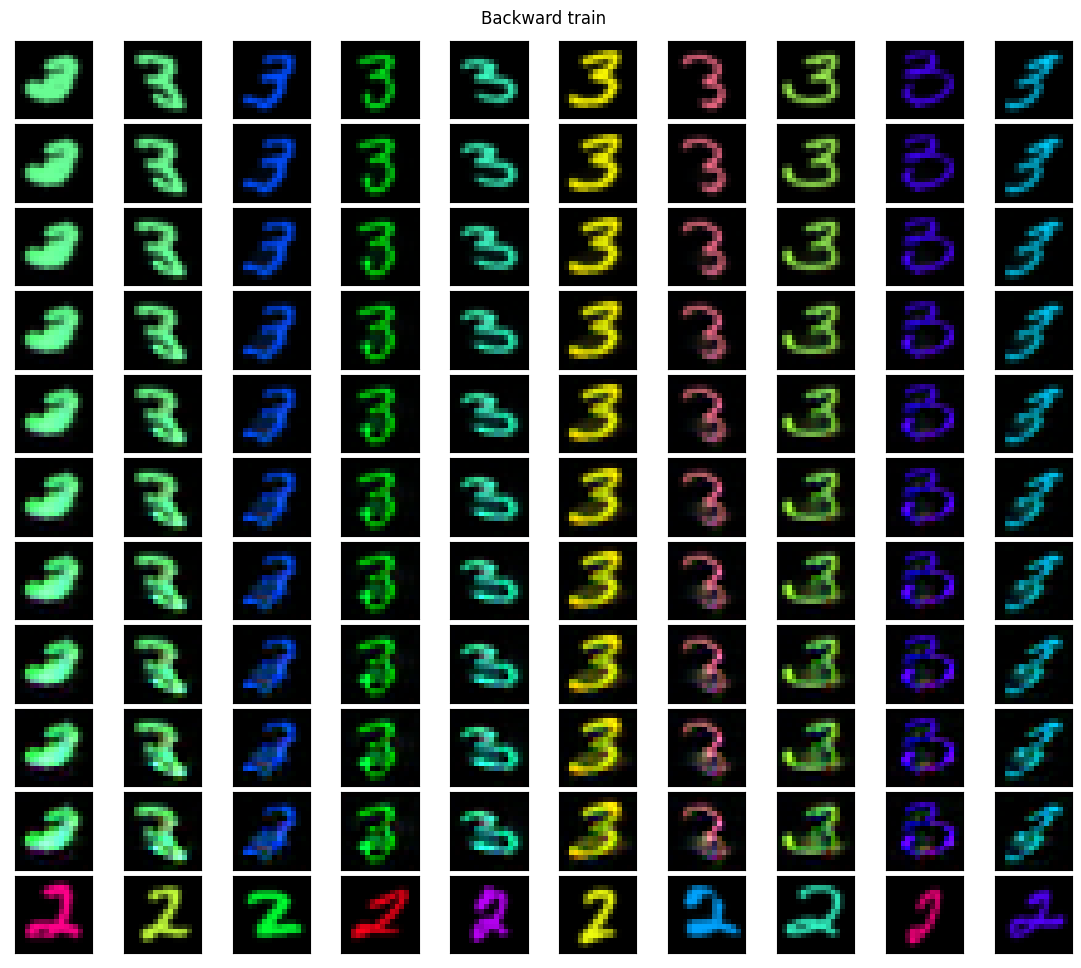

  0%|          | 300/100001 [1:06:57<359:44:53, 12.99s/it]

Plotting


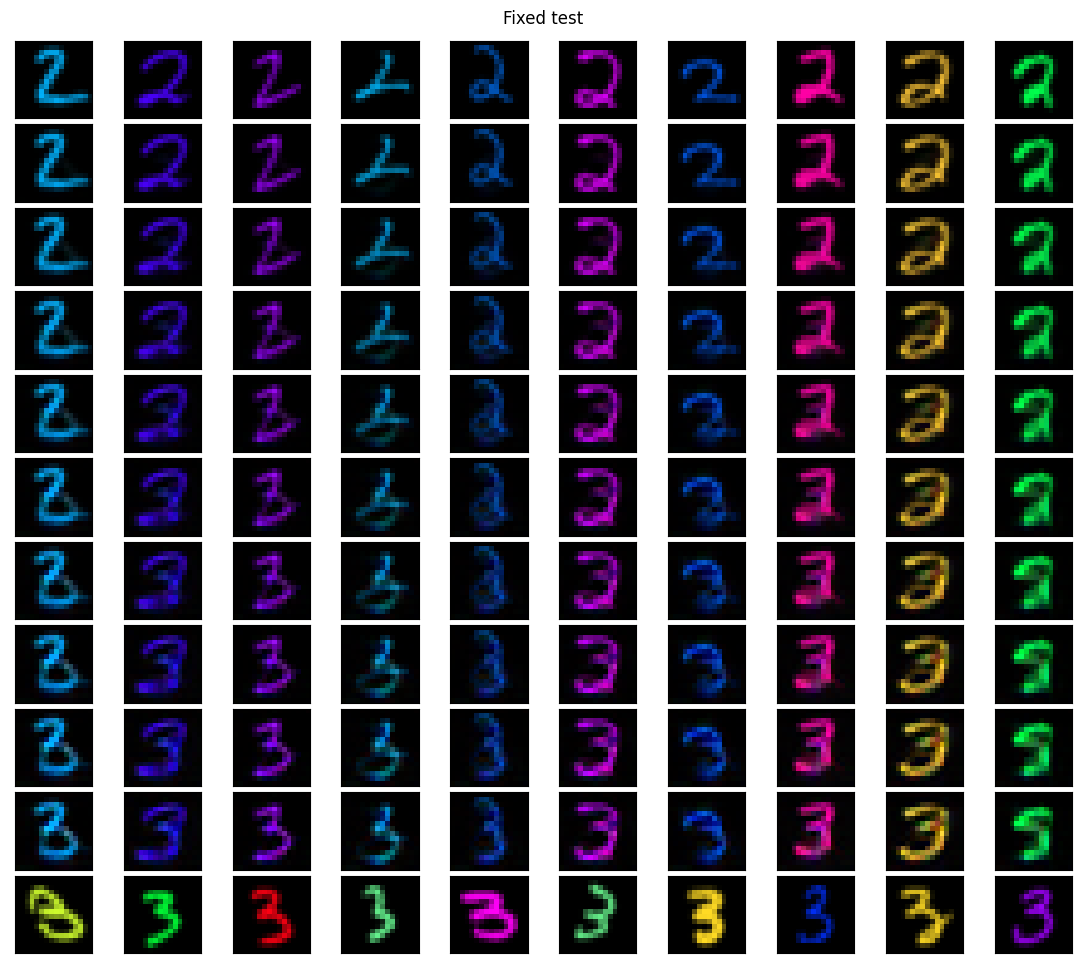

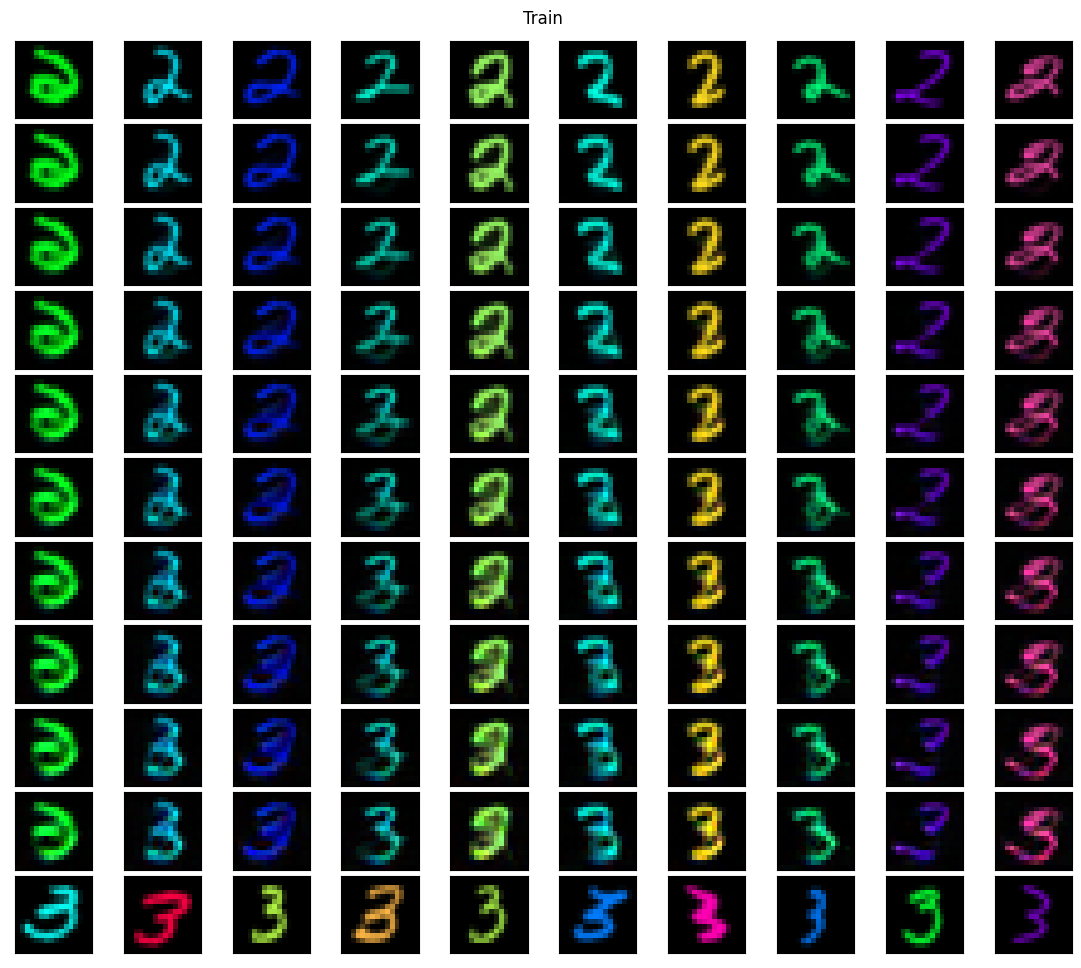

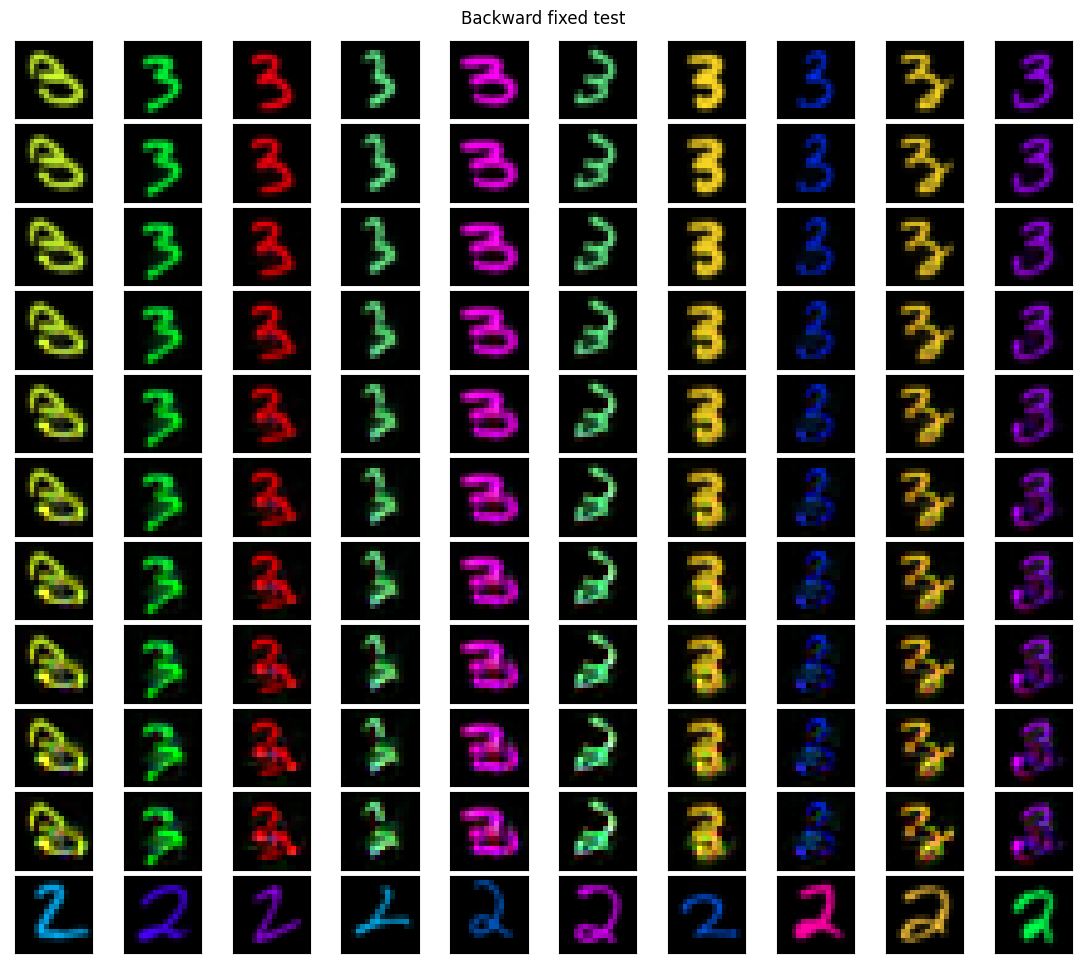

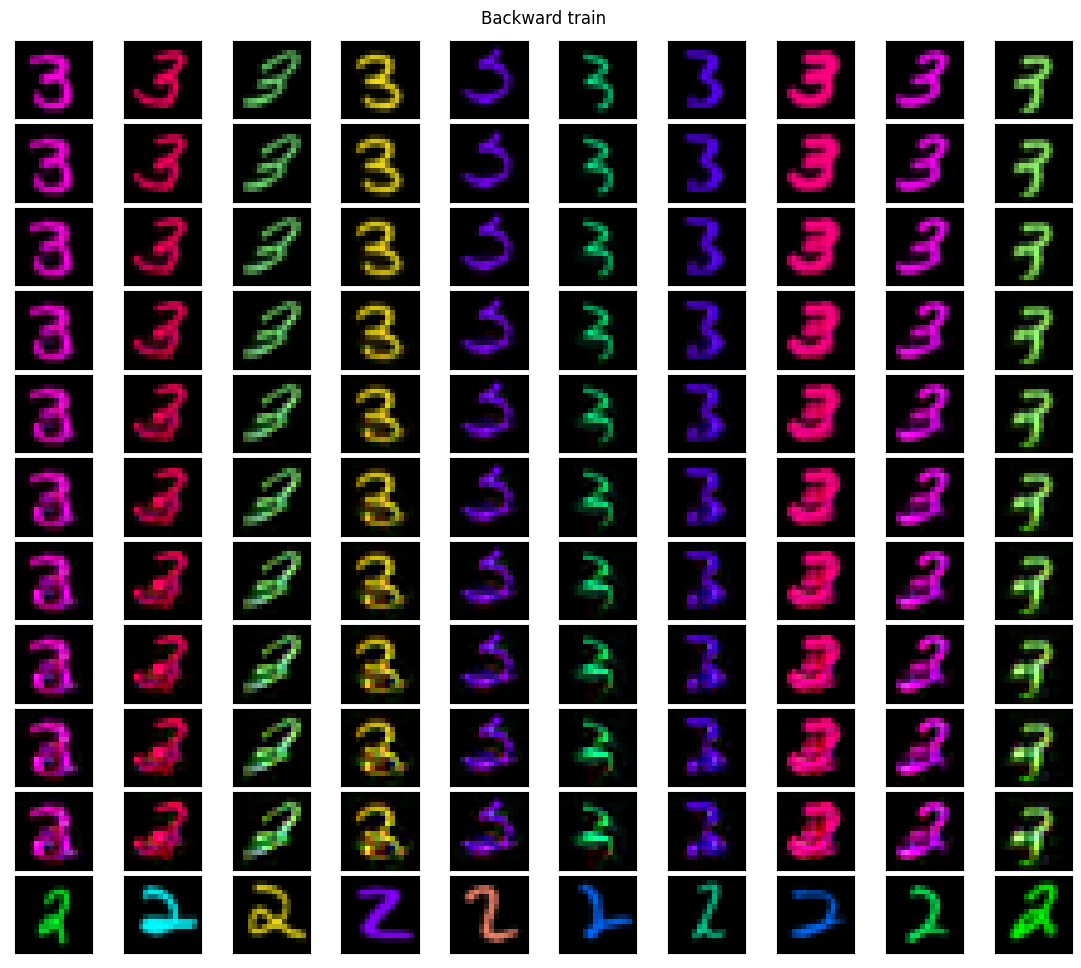

  0%|          | 400/100001 [1:29:03<319:49:25, 11.56s/it]

Plotting


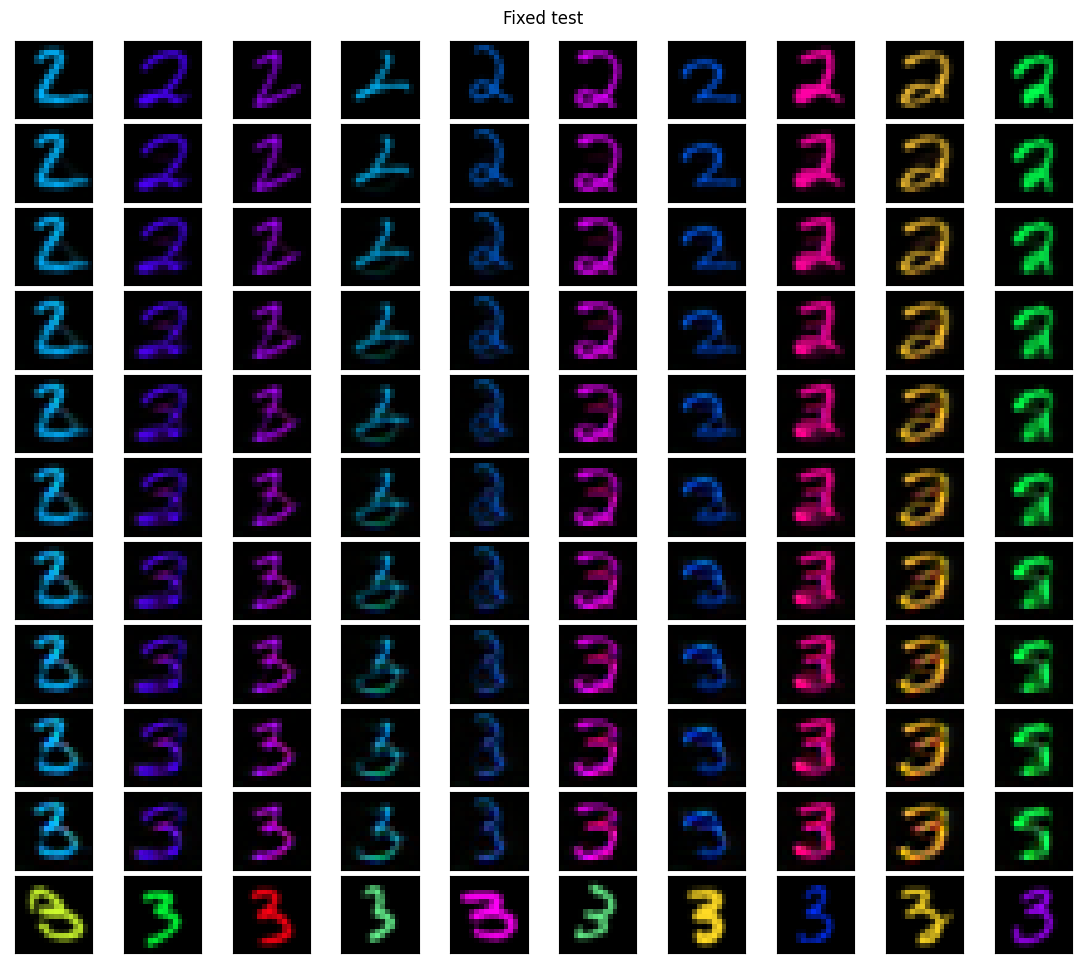

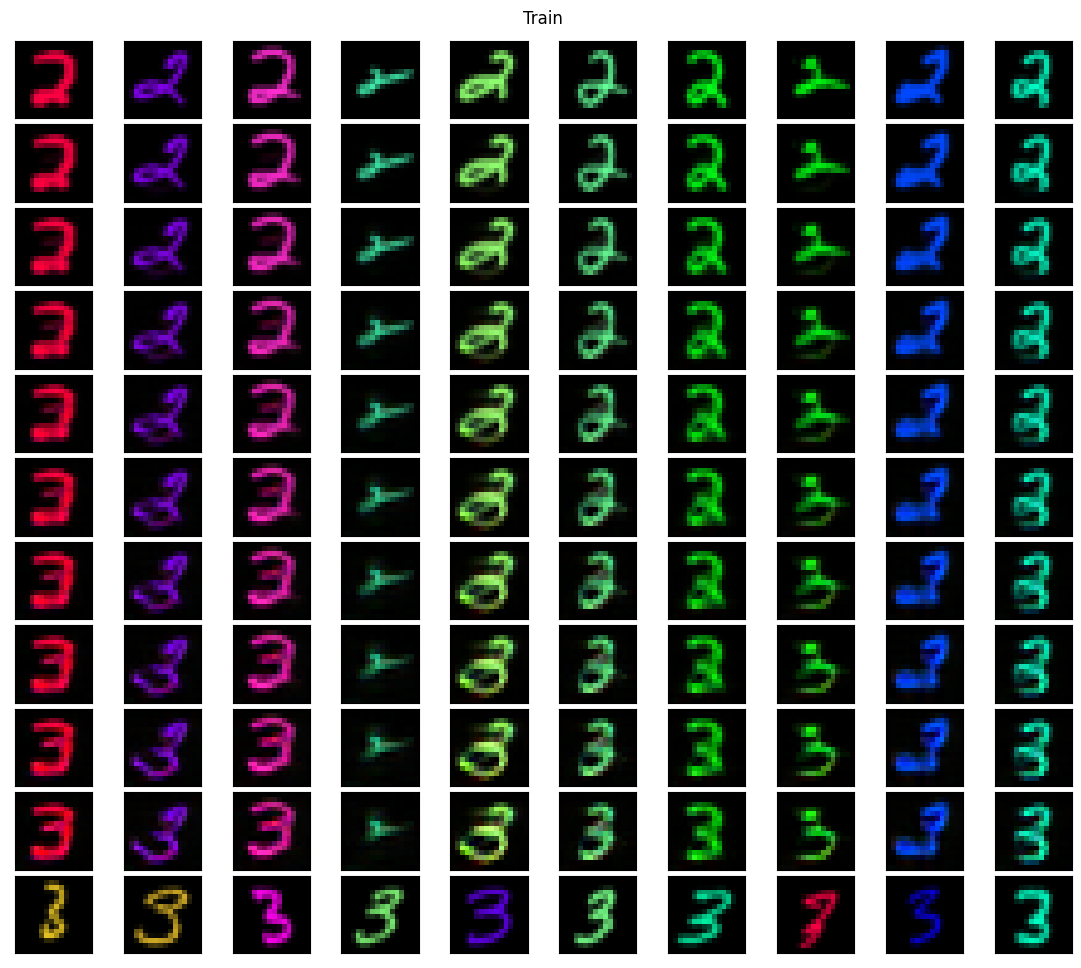

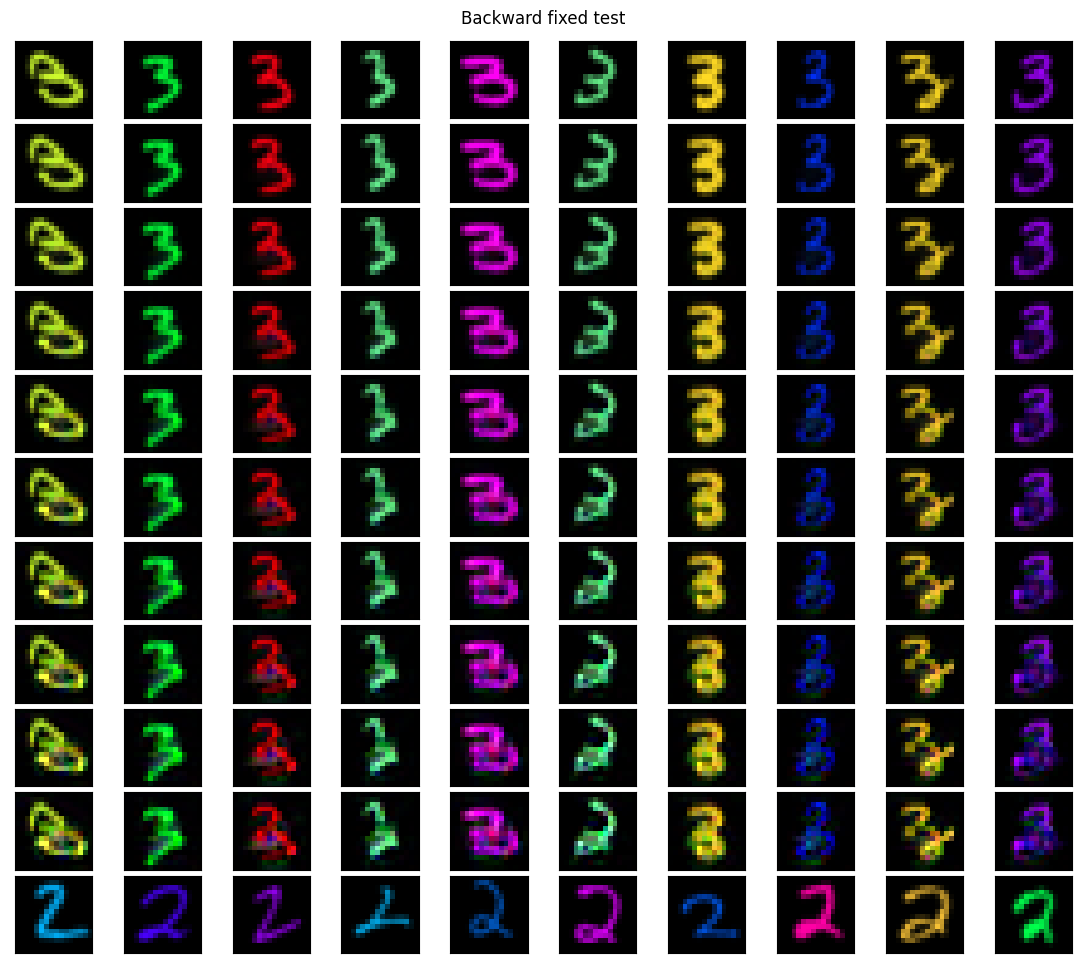

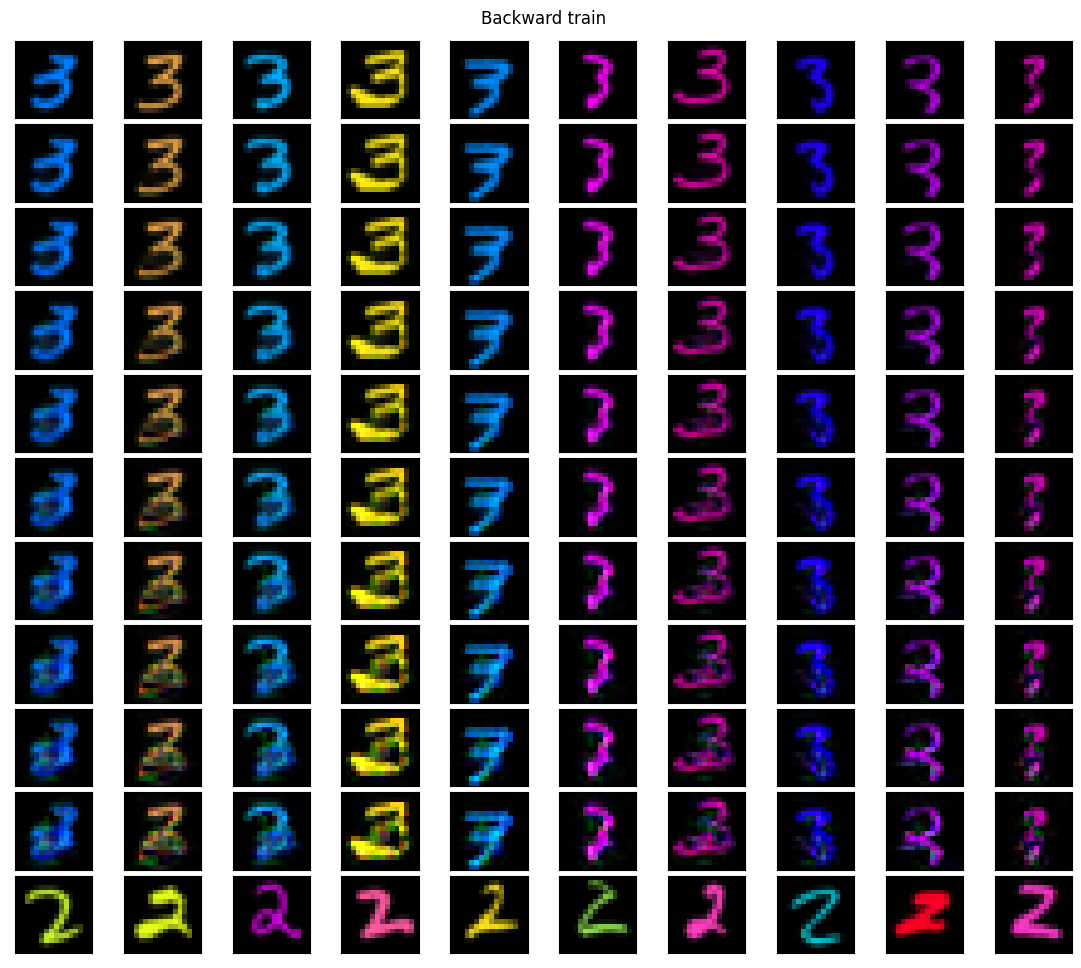

  0%|          | 500/100001 [1:51:31<356:50:56, 12.91s/it]

Plotting


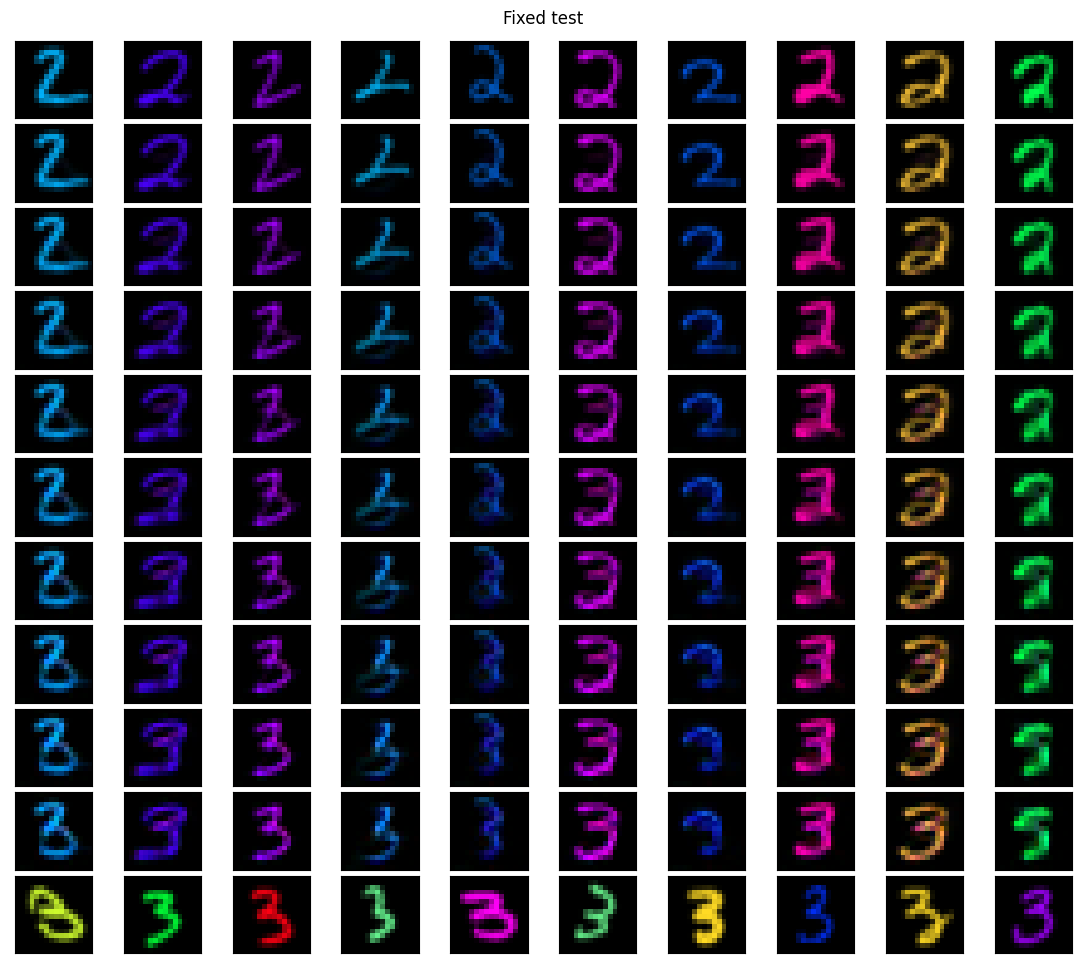

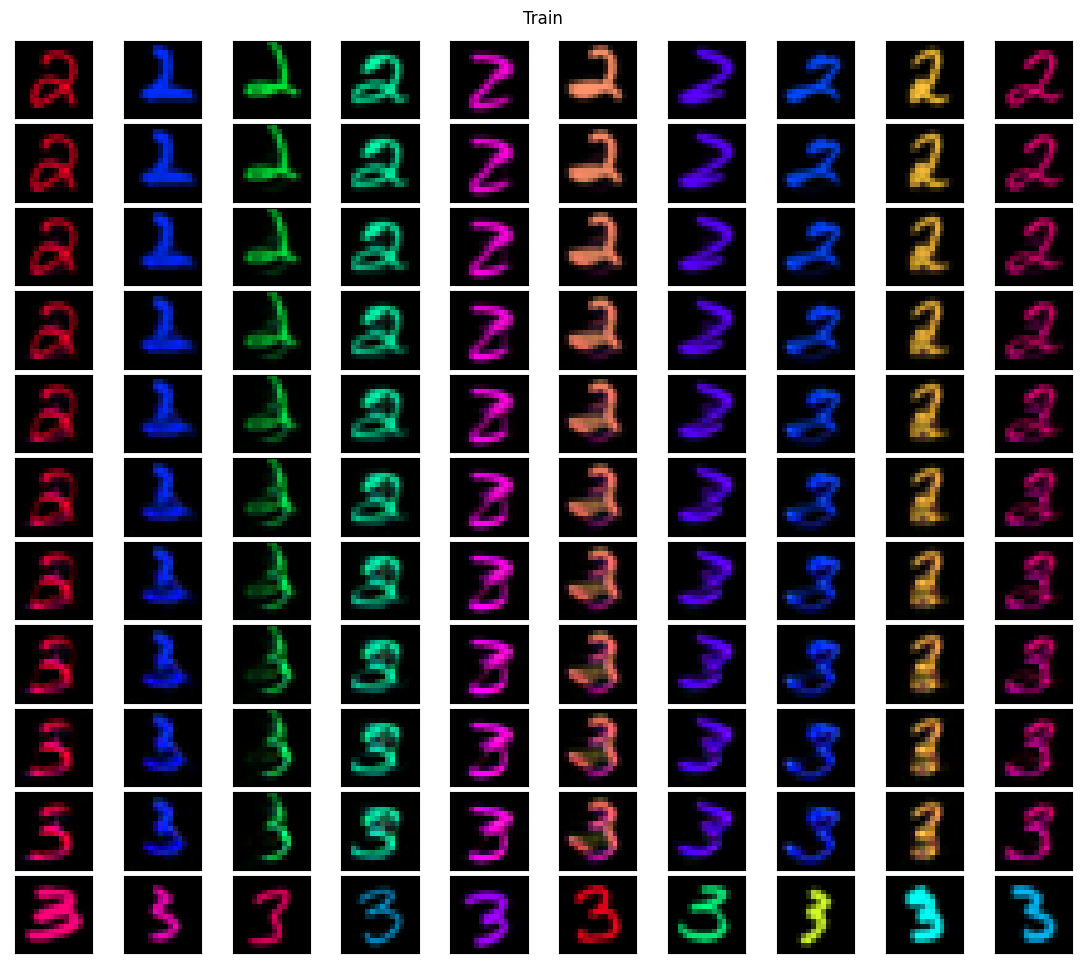

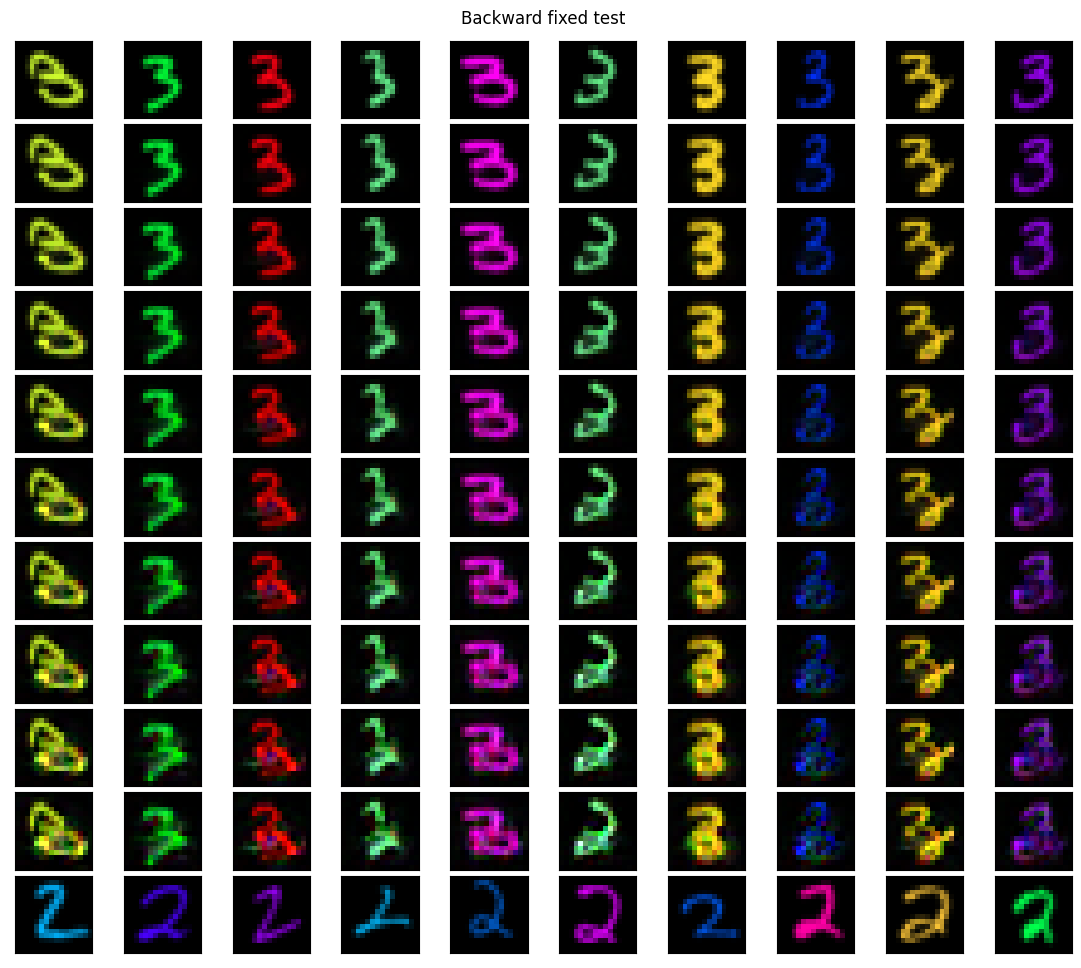

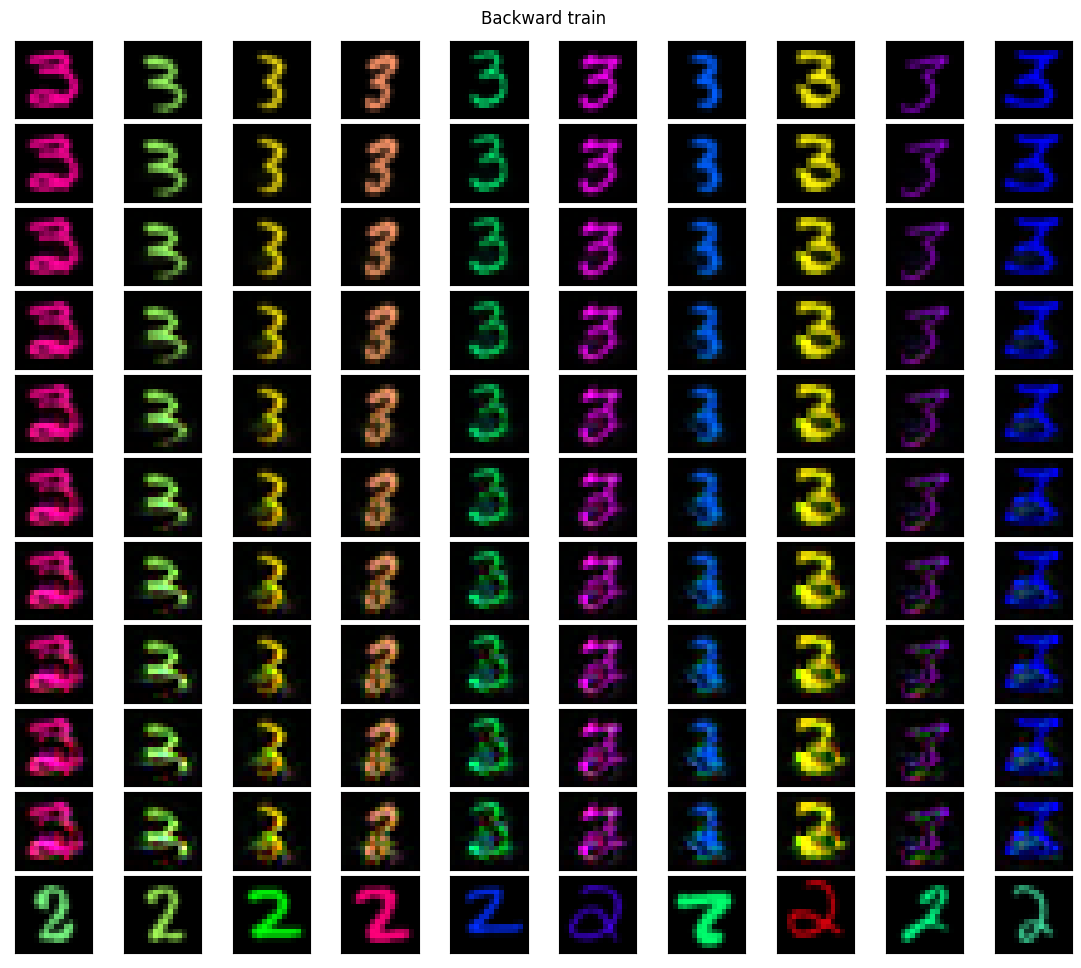

  1%|          | 526/100001 [1:58:04<365:16:39, 13.22s/it]

In [ ]:
PLOT_INTERVAL = 100
CPKT_INTERVAL = 1000
# PLOT_INTERVAL = 1
# CPKT_INTERVAL = 1
train_loop(T, f, sample_mnist_2, sample_mnist_3, BATCH_SIZE=64)


In [ ]:
torch.save(T.state_dict(), f'checkpoints/dynamic_ot_euler10step_MNIST_23_adjoint/{SEED}_last.pt')
torch.save(f.state_dict(), f'checkpoints/dynamic_ot_euler10step_MNIST_23_adjoint/f_{SEED}_last.pt')
torch.save(f_opt.state_dict(), f'checkpoints/dynamic_ot_euler10step_MNIST_23/f_opt_{SEED}_last.pt')
torch.save(T_opt.state_dict(), f'checkpoints/dynamic_ot_euler10step_MNIST_23_adjoint/T_opt_{SEED}_last.pt')

In [ ]:
figs, axes = plot_trajectories(T, BATCH_SIZE,
                              sample_mnist_2,
                              sample_mnist_3,
                              num_steps=10,
                              backward=False)

In [ ]:
figs, axes = plot_trajectories(T, BATCH_SIZE,
                              sample_mnist_2,
                              sample_mnist_3,
                              num_steps=10,
                              backward=True)

In [ ]:
figs[0].savefig('MNIST_23_backward_test.png')
figs[1].savefig('MNIST_23_backward_train.png')